In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import copy
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import pandas as pd
import pickle



# 하이퍼파라미터 설정
batch_size = 64
epochs = 10
lr = 0.01
PCA_dim = 8
CLS_num = 2



with open('./data.pkl','rb') as file:
    data = pickle.load(file)
X = data['X']
y = data['Y']



x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



def Fit_to_quantum(X,PCA_dim):
    pca = PCA(n_components=PCA_dim)
    X_pca = pca.fit_transform(X)
    return X_pca
    



# PyTorch Tensor로 변환
x_train_pca, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
x_test_pca, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)


class Feature_data_loader(Dataset):
    def __init__(self,x_train,y_train):
        self.feature1 = x_train
        temp = copy.deepcopy(x_train)
        shuffle = torch.randperm(len(temp))
        self.feature2 = temp[shuffle]
        self.y1 = y_train
        temp_y = copy.deepcopy(y_train)
        self.y2 = temp_y[shuffle]
        
    def __len__(self):
        return len(self.feature1)
    def __getitem__(self,idx):
        input1 = self.feature1[idx]
        input2 = self.feature2[idx]
        if self.y1[idx] == self.y2[idx]:
            label = torch.tensor(1.).float()
        else:
            label = torch.tensor(0.).float()
        return [input1,input2],label


# DataLoader 생성


feature_loader = DataLoader(Feature_data_loader(x_train_pca, y_train.float()),batch_size=batch_size,shuffle=True)
test_feature_loader = DataLoader(Feature_data_loader(x_test_pca, y_test.float()),batch_size=batch_size,shuffle=False)
train_loader = DataLoader(TensorDataset(x_train_pca, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_pca, y_test), batch_size=batch_size, shuffle=False)


In [2]:
from kan import KAN, create_dataset
def reg(acts_scale,KAN_layer, factor=1,lamb_l1=1.,lamb_entropy=2.,lamb_coef=0.,lamb_coefdiff=0.):

    def nonlinear(x, th=1e-16):
        return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

    reg_ = 0.
    for i in range(len(acts_scale)):
        vec = acts_scale[i].reshape(-1, )

        p = vec / torch.sum(vec)
        l1 = torch.sum(nonlinear(vec))
        entropy = - torch.sum(p * torch.log2(p + 1e-4))
        reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

    # regularize coefficient to encourage spline to be zero
    for i in range(len(KAN_layer.act_fun)):
        coeff_l1 = torch.sum(torch.mean(torch.abs(KAN_layer.act_fun[i].coef), dim=1))
        coeff_diff_l1 = torch.sum(torch.mean(torch.abs(torch.diff(KAN_layer.act_fun[i].coef)), dim=1))
        reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

    return reg_
def accuracy(pred, true):
    # 예측값이 로짓 혹은 확률값인 경우, 최대 값을 가진 인덱스를 구함 (가장 확률이 높은 클래스)
    pred = pred.detach().cpu()
    true = true.cpu()
    try:
        pred_labels = torch.argmax(pred, dim=1)
    except:
        pred_labels = torch.round(pred)
    # 예측 레이블과 실제 레이블이 일치하는 경우를 계산
    correct = (pred_labels == true).sum()
    # 정확도를 계산
    acc = correct / true.size(0)
    return acc.item() 

class Early_stop_train():
    def __init__(self,model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        

        
        self.loss_list = [1e100]
        self.acc_list = []
        self.stop_count = 0
        
    def train_model(self,train_loader,test_loader=None ,epochs=200,res = 10,lamb=0.):
        #self.model.train()
        
        for epoch in range(epochs):
            if self.stop_count>=res:
                break
            loss_val,_ = self.test(test_loader)
            self.loss_list.append(loss_val)
            
            if self.loss_list[-1]>=np.min(self.loss_list[:-1]):
                self.stop_count+=1
            else:
                self.optimal = self.model.state_dict()
                self.stop_count = 0
            loss_list = []
            acc_list = []
            for X_train,y_train in train_loader:
                self.optimizer.zero_grad()
                output = self.model(X_train)
                reg_ = lamb*reg(self.model.KAN.acts_scale,self.model.KAN)
                try:
                    loss = self.criterion(output.squeeze(), y_train)+reg_
                except:
                    print(output)
                    raise
                loss.backward()
                self.optimizer.step()
                loss_list.append(loss.item())
                acc = accuracy(output,y_train)
                acc_list.append(acc)
                sys.stdout.write(f"\rEpoch {epoch+1} Loss {np.mean(loss_list):4f} acc : {np.mean(acc_list):4f} reg : {reg_:4f} stop count : {self.stop_count}")
        self.model.load_state_dict(self.optimal)
    def test(self,test_loader):
        if test_loader is None:
            return 0,0
        else:
            #self.model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    output = self.model(data)

                    test_loss += self.criterion(output.squeeze(), target).item()
                    
                    correct += accuracy(output,target)*len(output)

            print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')
            return test_loss,correct

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pennylane as qml
from pennylane import numpy as np
import math

result_list_classical = []
# 데이터 로드 및 전처리
"""
data = load_breast_cancer()
X = data.data
y = data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=PCA_dim)
X_pca = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.PCA_dim, random_state=seed)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)"""

# Pennylane 장치 설정
dev = qml.device("default.qubit", wires=PCA_dim)


def ZZFeatureMapLayer(features, wires):
    """사용자 정의 ZZFeatureMap 레이어"""
    index = 0
    for i in wires:
        qml.Hadamard(wires=i)
        qml.RZ(features[:,index], wires=i)
        index += 1

    for j in range(0, len(wires)-1):
        qml.CNOT(wires=[j, j+1])
        qml.RZ((features[:,index]), wires=j+1)
        qml.CNOT(wires=[j, j+1])
        index+=1

def ansatz(params):
    for j in range(len(params)):
        # 각 큐비트에 대해 RX, RY, RZ 회전 적용
        for i in range(len(params[0])):
            qml.RY(params[j, i, 0], wires=i)
            qml.RZ(params[j, i, 1], wires=i)
            
        # 인접한 큐비트 간 CNOT 게이트로 엔탱글링
        if j == len(params)-1:
            pass
        else:
            for i in range(len(params[0])-1):
                qml.CNOT(wires=[i, i+1])


# 양자 레이어 정의
@qml.qnode(dev, interface='torch')
def QuantumLayer(features,params):
    ZZFeatureMapLayer(features, wires=range(PCA_dim))
    ansatz(params)
    return qml.probs(wires=range(math.ceil(math.log2(CLS_num))))


## 양자 커널
@qml.qnode(dev, interface='torch')
def Kernal(features1,features2):
    ZZFeatureMapLayer(features1, wires=range(PCA_dim))
    qml.adjoint(ZZFeatureMapLayer)(features2,wires=range(PCA_dim))
    return qml.probs(wires=range(PCA_dim))


class Feature_model(nn.Module):
    def __init__(self):
        super(Feature_model,self).__init__()
        KAN_model = KAN([PCA_dim,PCA_dim*4+1,PCA_dim*2-1],grid=5,)
        """
        for i in range(PCA_dim):
            temp_list = [i for i in range(PCA_dim*2-1)]
            temp_list.remove(i)
            for j in temp_list:
                KAN_model.remove_edge(0,i,j)
        for i in range(PCA_dim-1):
            if i == 0:
                temp_list = [i for i in range(PCA_dim*2-1)]
                temp_list.remove(i+PCA_dim)
                for j in temp_list:
                    KAN_model.remove_edge(0,i,j)
            elif i == PCA_dim-2:
                temp_list = [i for i in range(PCA_dim*2-1)]
                temp_list.remove(PCA_dim*2-2)
                for j in temp_list:
                    KAN_model.remove_edge(0,i,j)
            else:
                temp_list = [i for i in range(PCA_dim*2-1)]
                temp_list.remove(i+PCA_dim)
                temp_list.remove(i+PCA_dim-1)
                for j in temp_list:
                    KAN_model.remove_edge(0,i,j)
                    
        for i in range(2*PCA_dim-1):
            temp_list = [i for i in range(PCA_dim*2-1)]
            temp_list.remove(i)
            for j in temp_list:
                KAN_model.remove_edge(1,i,j)
        """
        self.KAN = KAN_model
        self.Kernal = Kernal
    def forward(self,inputs):
        epsilon = 1e-6
        input1 = inputs[0]
        #input1_copy = input1.clone().detach().requires_grad_(True)
        input2 = inputs[1]
        #input2_copy = input2.clone().detach().requires_grad_(True)
        input1 = nn.Sigmoid()(self.KAN(input1))*np.pi
        #input1 = torch.concat([input1,input1_copy],dim=1)
        input2 = nn.Sigmoid()(self.KAN(input2))*np.pi
        #input2 = torch.concat([input2,input2_copy],dim=1)
        output = self.Kernal(input1,input2)
        output = output.type(torch.float32)
        
        return output[:,0].clamp(min=epsilon, max=1-epsilon)
        
    



# 하이브리드 모델 정의
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.KAN = feature_model.KAN
        
        self.quantum_layer = QuantumLayer
        self.Q_params = nn.Parameter((torch.rand([PCA_dim,PCA_dim,2])*2-1)*np.pi,requires_grad=True)
    def forward(self, x):
        x = nn.Sigmoid()(self.KAN(x))*np.pi
        #print(qml.draw(self.quantum_layer)(x,self.Q_params))
        quantum_output = self.quantum_layer(x,self.Q_params)
        quantum_output = quantum_output.type(torch.float32)
        return torch.log(quantum_output)
    

feature_model = Feature_model(); criterion = nn.BCELoss()


optimizer = optim.Adam(feature_model.parameters(), lr=0.01)



# 모델 학습 및 평가
train_process = Early_stop_train(feature_model, optimizer, criterion)
train_process.train_model(feature_loader,test_feature_loader,epochs=50,res=15,lamb=0.01)
#feature_model.KAN.plot(beta=3,scale=2)
feature_model.KAN = feature_model.KAN.prune()
_,acc = train_process.test(test_feature_loader)
print(f"\n Pretrain acc : {acc}")

model = HybridModel(); criterion = nn.NLLLoss()

for param in model.KAN.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model.parameters(), lr=0.01)
print("\n\nTest start\n\n")
train_process = Early_stop_train(model, optimizer, criterion)
train_process.train_model(train_loader,test_loader,epochs=15,lamb=0)

_,acc = train_process.test(test_loader)
result_list_classical.append(acc)
print(f"Test Accuracy: {acc:.2f}")




Test set: Average loss: 5.3539, Accuracy: 153.00000059604645/300 (51%)
Epoch 1 Loss 1.515659 acc : 0.531345 reg : 0.688182 stop count : 0
Test set: Average loss: 3.2577, Accuracy: 198.00000047683716/300 (66%)
Epoch 2 Loss 1.218028 acc : 0.713731 reg : 0.617178 stop count : 0
Test set: Average loss: 2.3121, Accuracy: 233.99999928474426/300 (78%)
Epoch 3 Loss 1.021374 acc : 0.839773 reg : 0.589290 stop count : 0
Test set: Average loss: 2.0125, Accuracy: 247.00000071525574/300 (82%)
Epoch 4 Loss 0.923588 acc : 0.856818 reg : 0.559980 stop count : 0

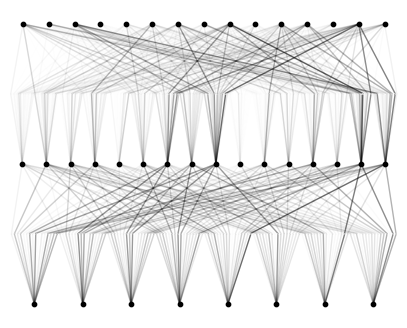

In [ ]:
feature_model.KAN.plot()